#### Minimum Weight-Perfect Matching Weight Calibration Evaluation

In this notebook we evaluate the single qubit lifetime for different MWPM weights

In [23]:
from deepq.Function_Library import *
from deepq.Environments import *

import numpy as np
import matplotlib.pyplot as plt

In [25]:
d = 5
error_model = "DP"
p_phys = 0.001
p_meas = p_phys
total_steps = 20_000
p_phys_list = [0.001, 0.003, 0.007, 0.009, 0.013]
mwpm_scale = {}

for scale in [0., .1, .3, .5]:
  mwpm_scale[scale] = {}
  for p_phys in p_phys_list:
    mwpm_scale[scale][p_phys] = {}
    p_meas = p_phys
    mwpm_weights = np.random.normal(loc=1, scale=scale, size=(d**2+1,))

    noise_model = NoiseFactory(error_model, d, p_phys).generate()
    env = Surface_Code_Environment_Multi_Decoding_Cycles(d=d,
                                                        p_meas=p_meas,
                                                        noise_model=noise_model,
                                                        use_Y=False,
                                                        volume_depth=d,
                                                        static_decoder=None,
                                                        mwpm_weights=mwpm_weights)

    env.reset()
    avg_qubit_lifetime_steps = []
    avg_env_steps = []
    steps = 0
    for _ in range(total_steps):
      # we do not correct any qubits and apply identity action
      _, _, done, _ = env.step(env.identity_index)
      if done:
        # print(f"Encountered Episode end, steps: {steps}, done: {done}, lifetime: {env.lifetime}")
        avg_qubit_lifetime_steps.append(env.lifetime)
        avg_env_steps.append(steps)
        env.reset()
        steps = 0

      steps += int(not done)

    avg_qubit_lifetime_steps.append(env.lifetime)
    avg_env_steps.append(steps)

    print(f"stddev: {scale}")
    print(f"Avg. Qubit lifetime: {np.mean(avg_qubit_lifetime_steps)}")
    print(f"Avg. Environment steps: {np.mean(avg_env_steps)}")
    mwpm_scale[scale][p_phys]['avg_qubit_lifetime'] = np.mean(avg_qubit_lifetime_steps)
    mwpm_scale[scale][p_phys]['avg_env_steps'] = np.mean(avg_env_steps)

Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.001
stddev: 0.0
Avg. Qubit lifetime: 280.3292682926829
Avg. Environment steps: 47.78292682926829
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.003
stddev: 0.0
Avg. Qubit lifetime: 105.05560704355885
Avg. Environment steps: 17.53660797034291
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.007
stddev: 0.0
Avg. Qubit lifetime: 47.3734693877551
Avg. Environment steps: 7.1636734693877555
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.009
stddev: 0.0
Avg. Qubit lifetime: 39.75535168195719
Avg. Environment steps: 5.796126401630989
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.013
stddev: 0.0
Avg. Qubit lifetime: 30.2475
Avg. Environment steps: 4.00025
Using DP Noise (stddev 0.0), with physical qubit error distribution: 
0.001
stddev: 0.1
Avg. Qubit lifetime: 271.25586854460096
Avg. Environment steps: 45.95070422535211
Usin

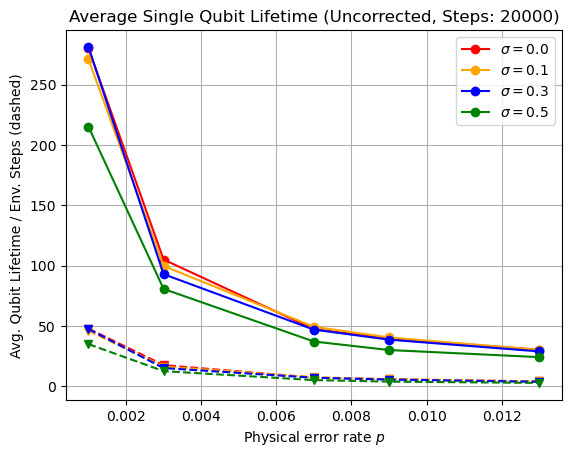

In [32]:
colors = ['red', 'orange', 'blue', 'green']

for index, scale in enumerate([0., .1, .3, .5]):
  avg_qubit = [mwpm_scale[scale][p]['avg_qubit_lifetime'] for p in p_phys_list]
  avg_env = [mwpm_scale[scale][p]['avg_env_steps'] for p in p_phys_list]
  plt.plot(p_phys_list, avg_qubit, marker='o', color=colors[index], label=str(f"$\sigma={scale}$"))
  plt.plot(p_phys_list, avg_env, marker='v', color=colors[index], linestyle='--')
plt.title(f"Average Single Qubit Lifetime (Uncorrected, Steps: {total_steps})")
plt.xlabel('Physical error rate $p$')
plt.ylabel('Avg. Qubit Lifetime / Env. Steps (dashed)')
plt.grid()
plt.legend()
plt.savefig('avg_single_qubit_lifetime_mwpm_weight_calibration.png', dpi=300)